In [16]:
%matplotlib inline
from __future__ import division, absolute_import
import os
import skimage
from skimage import io
from skimage import color
import numpy as np
from scipy import signal
import scipy.signal.signaltools as sigtool
import matplotlib.pyplot as plt


# get list of images
def get_list_of_images(image_dir):
    list_of_images = []
    for file in os.listdir(image_dir):
        if file.endswith('.jpg'):
            list_of_images.append(file)

    return list_of_images


# get the luminance channel of image
def get_lum_channel(sk_image):
    image_lab = skimage.color.rgb2lab(sk_image)
    image_l = skimage.color.rgb2gray(image_lab[:, :, 0])

    return image_l


# get the middle 3rd of the image in x or y
def get_mid_3rd(sk_image, direction):
    if direction == 'width':
        direction_id = 1
    elif direction == 'height':
        direction_id = 0
    else:
        print('include width or height as direction')
    img_length = sk_image.shape[direction_id]
    third = int(np.floor(img_length / 3))
    middle_section = sk_image[third:2 * third, :]

    return middle_section


# generate graph of brightness in x or y
def get_luma_sums(middle_section, direction):
    if direction == 'width':
        direction_id = 0
    elif direction == 'height':
        direction_id = 1
    else:
        print('include direction for summation')
    summation = np.sum(middle_section, axis=direction_id)

    return summation


# round up to nearest odd number
def round_up_to_odd(f):
    f = int(np.ceil(f))
    return f + 1 if f % 2 == 0 else f


# filter luminance channel sum
def smooth_values(sum_of_luma):
    window_length = round_up_to_odd(sum_of_luma.shape[0] / 100)
    x_filtered = signal.savgol_filter(sum_of_luma, window_length, 0)

    return x_filtered


# square wave of luminance channel sum
def make_luma_binary(sum_of_luma):
    env = np.abs(sigtool.hilbert(sum_of_luma))
    threshold = np.mean(sum_of_luma) * 1.5
    square_sig = (env > threshold)

    return square_sig


def get_edge_point(square_wave, direction):
    """
    Find the edge values for cropping on one side of the image
    :param square_wave: square wave from sum of luma channel
    :param direction: 0 for from left, 1 for from right
    :return: edge point value
    """
    length = len(square_wave)
    length_third = int(np.floor(length/3))
    if direction == 0:
        search_array = square_wave[0:length_third]
        indices = np.nonzero(search_array)
        edge = np.argmax(indices)
    if direction == 1:
        search_array = square_wave[2*length_third:-1]
        indices = np.nonzero(search_array)
        edge = np.argmin(indices) + 2*length_third

    return edge


# get edges of card
def get_bndbox(image):
    """
    Cacluate the bounding box for the right/left pair in a stereocard
    :param image: scikit-image image
    :return: [xmin, xmax, ymin, ymax]
    """
    img_luma = get_lum_channel(image)

    # for x direction
    middle_width = get_mid_3rd(img_luma, 'width')
    x_sums = get_luma_sums(middle_width, 'width')
    x_binary = make_luma_binary(x_sums)
    xmin = get_edge_point(x_binary, 0)
    xmax = get_edge_point(x_binary, 1)

    # for y direction
    middle_height = get_mid_3rd(img_luma, 'height')
    y_sums = get_luma_sums(middle_height, 'height')
    y_binary = make_luma_binary(y_sums)
    ymin = get_edge_point(y_binary, 0)
    ymax = get_edge_point(y_binary, 1)

    bndbox =  [xmin, xmax, ymin, ymax]

    print('bbox is', bndbox)
    return bndbox

In [18]:
image_number = 10
image_list = get_list_of_images('/Volumes/Zweiter/VVR/FL/')
this_image = io.imread('/Volumes/Zweiter/VVR/FL/' + image_list[image_number])

card_bbox = get_bndbox(this_image)
new_image = this_image[card_bbox[2]:card_bbox[3], card_bbox[0]:card_bbox[1]]
    
io.imshow(new_image)
io.show()

ValueError: attempt to get argmax of an empty sequence

 ...]

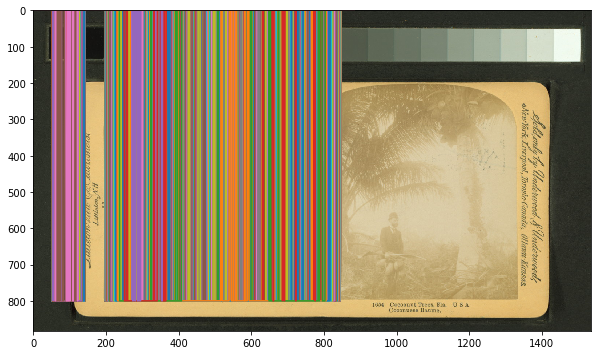

In [7]:
img_luma = get_lum_channel(this_image)
square_sig = make_luma_binary(img_luma)
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 6))
ax1.imshow(this_image)
ax1.plot(square_sig*800)